# Time Series - Example Part 2
This notebook is a continuation of Toronto temperature dataset. In Part 1 we implemented Facebook's Prophet modeler. In this notebook we will load the preprocessed data from earlier to see how a neural network using Gated Recurrent Units (GRUs) will fare with the data. We will be using Tensorflow with the Keras API for this neural network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

print('Tensorflow Version: ', tf.__version__)
print('Keras Version: ', tf.keras.__version__)
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version:  2.4.1
Keras Version:  2.4.0
Num GPUs Available:  1


In [3]:
toronto_preprocessed = pd.read_csv('../data/toronto_preprocessed.csv')
toronto_preprocessed.head()

,ds,y
0,1937-11-01,3.3
1,1937-12-01,-4.4
2,1938-01-01,-7.2
3,1938-02-01,-3.7
4,1938-03-01,1.4


In [4]:
toronto_rnn = toronto_preprocessed[26:].set_index('ds') #removing null values existing before 1940
toronto_rnn.head()

,y
ds,
1940-01-01,-9.4
1940-02-01,-6.2
1940-03-01,-5.2
1940-04-01,4.1
1940-05-01,11.7


In [5]:
toronto_rnn.shape

(947, 1)

Text(0, 0.5, 'Temperatures')

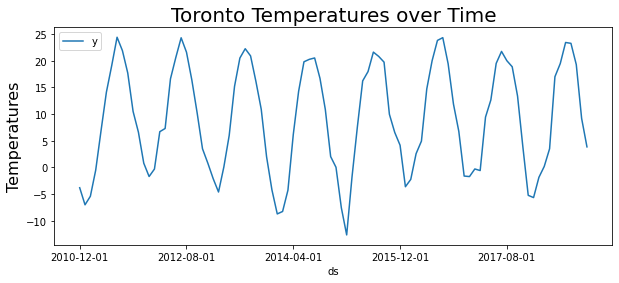

In [6]:
toronto_rnn[-96:].plot(figsize=(10,4))
plt.title('Toronto Temperatures over Time', fontsize=20)
plt.ylabel('Temperatures', fontsize=16)

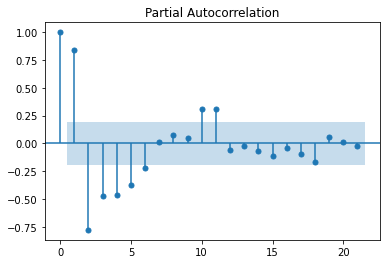

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(toronto_rnn.loc['2010-01':].y)
plt.show()

### Note:
Based on the Partial Autocorrelation graph we will use a window of 11. We might also consider using a window of 6 but for the purposes of this example we will stick to a window of size 11.

In [8]:
#window size hyperparameter
window_size = 11

# Data Preparation

In [9]:
def sliding_window(y_series,window_size):
    perm_list = []
    for i in range(len(y_series) - window_size):
        temp_list = []
        perm_list.append(temp_list)
        for n in range(window_size):
            temp_list.append(y_series[n+i])
    X_array = np.expand_dims(np.array(perm_list),axis=2) #expanded axis for readability in keras
    y_array = np.array(y_series[window_size:])
    return X_array, y_array

In [10]:
X, y = sliding_window(toronto_rnn.y, window_size )

In [11]:
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (941, 6, 1)
Shape of y: (941,)


In [12]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, shuffle=False)

# Building the Neural Network

In [13]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, GRU, Dropout

input_shape = (window_size,1)
drop_rate = 0.5

model = Sequential()  
model.add(GRU(600, activation = "relu", input_shape = input_shape, return_sequences=True))
#model.add(Dropout(drop_rate))
model.add(GRU(300, activation = "relu", input_shape = input_shape, return_sequences=True))
#model.add(Dropout(drop_rate))
model.add(GRU(150, activation = "relu", input_shape = input_shape, return_sequences=True))
#model.add(Dropout(drop_rate))
model.add(GRU(75, activation = "relu", input_shape = input_shape))
model.add(Dense(1))

In [14]:
model.compile(optimizer='adam',
              loss='mse')

In [15]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=25)]

validation_data=(X_valid,y_valid)

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=300,
                    batch_size=None,
                    callbacks=callbacks,
                    validation_data=validation_data)

Epoch 1/300
24/24 [==============================] - 9s 163ms/step - loss: 100.2663 - val_loss: 12.5119
Epoch 2/300
24/24 [==============================] - 2s 102ms/step - loss: 7.4459 - val_loss: 7.3335
Epoch 3/300
24/24 [==============================] - 2s 104ms/step - loss: 5.7406 - val_loss: 6.1959
Epoch 4/300
24/24 [==============================] - 3s 105ms/step - loss: 4.9073 - val_loss: 6.0290
Epoch 5/300
24/24 [==============================] - 2s 103ms/step - loss: 5.4104 - val_loss: 6.8329
Epoch 6/300
24/24 [==============================] - 2s 102ms/step - loss: 5.7078 - val_loss: 7.2207
Epoch 7/300
24/24 [==============================] - 3s 105ms/step - loss: 5.3451 - val_loss: 9.0127
Epoch 8/300
24/24 [==============================] - 2s 103ms/step - loss: 5.3846 - val_loss: 5.5261
Epoch 9/300
24/24 [==============================] - 2s 103ms/step - loss: 5.1244 - val_loss: 7.4691
Epoch 10/300
24/24 [==============================] - 2s 104ms/step - loss: 4.7789 - val

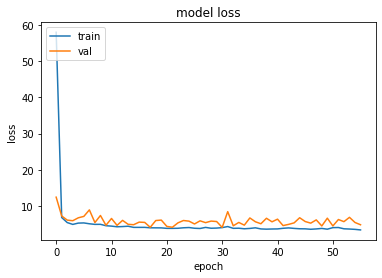

In [16]:
#Training v. Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Model Evaluation

In [17]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 14ms/step - loss: 5.9843


5.98427677154541

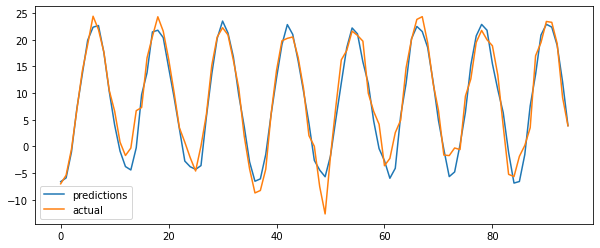

In [18]:
predictions = model.predict(X_test)
plt.figure(figsize=(10,4))
plt.plot(predictions,label='predictions')
plt.plot(y_test,label='actual')
plt.legend()

In [19]:
pred_df = pd.DataFrame(predictions,columns=['predictions'])
pred_df.head()

,predictions
0,-6.601014
1,-5.900877
2,-1.029050
3,7.115436
4,13.501894


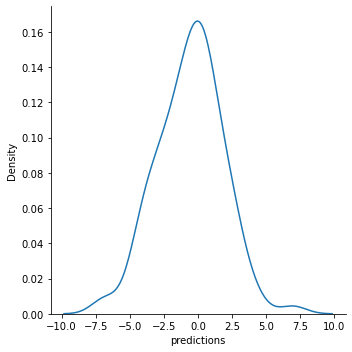

In [20]:
import seaborn as sns
residuals = pred_df.predictions - y_test
sns.displot(data=residuals,kind='kde')

In [21]:
from sklearn import metrics
import numpy as np

MAE = metrics.mean_absolute_error(y_test,predictions)
MAPE = metrics.mean_absolute_percentage_error(y_test,predictions) * 100
MSE = metrics.mean_squared_error(y_test,predictions)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,predictions))
MedAE = metrics.median_absolute_error(y_test,predictions)
MedAPE = np.median((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100

In [22]:
print('MAE:', np.round(MAE,2))
print('MAPE:', np.round(MAPE,2),'%')
print('MSE:', np.round(MSE,2))
print('RMSE:', np.round(RMSE,2))
print('MedAE:', np.round(MedAE,2))
print('MedAPE:',np.round(MedAPE,2),'%')

MAE: 1.89
MAPE: 204.48 %
MSE: 5.98
RMSE: 2.45
MedAE: 1.61
MedAPE: 112.51 %


# Analyzing the Results


We can observe that although the model is tracking well with thde actual predictions the predictions themselves are not necessarily in line with the actual results. In terms of the residuals of our RNN model compared to the residuals of the PROPHET model we should discuss the concept of kurtosis. Essentially, Kurtosis deals with how heavily the tails of the distribution differ from a standard normal distribution. Here, the residual distribution seems to exhibit more leptokurtic behavior. This means that the tails are longer leaving a narrower & pointer bell in the middle. Leptokurtic distributions tend to have more erratic behavior with more values appearing on the extremes of the distribution.

One possible reason for the erratic behavior of our predictions is likely due to the lack of time-series preprocessing one might expect for these types of predictions. Rather than removing seasonality and trends we simply created a window based on the PACF results and passed the series into the neural network. Seeing as neural networks are capable of complex tasks it would be nice to see the network catch on to the seasonal trends without having to manually preprocess the data to help our network find the underlying trends.

Having received the results we received we can see that this model would require a significant amount of alteration and experimentation before approaching the results that the PROPHET model achieved. PROPHET is specifically designed to handle time series data whereas neural networks are fairly general purpose with applications to a variety of topics. Neural networks are considered blackboxes where the methodology of the outputs of the network are not easily understood. This makes fine-tuning neural networks notoriously difficult and time-consuming. This is a case of choosing the right tool for the right job and for this particular tasks we would be better off using standard time series analysis tools.